<a href="https://colab.research.google.com/github/mrreyesm/NLP_tweets/blob/main/NLP_tweets_on_war.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
# For natural language processing
import nltk
nltk.download('punkt')
from nltk import word_tokenize
# For string manipulation
import string
# To create a word cloud with tweets
from wordcloud import WordCloud
#To visualize
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
os.environ['TOKEN'] = 'AAAAAAAAAAAAAAAAAAAAAKwsZwEAAAAARfPLFsHkhgzkATLhA4UJzvVEugQ%3DL3goAkl3kgtVBWw619JvpHPVGFJsOwetuedpvlozXPaaelGFTt'

In [3]:
def auth():
    return os.getenv('TOKEN')

In [4]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [5]:
def create_url(keyword, start_date, end_date, max_results = 10):
    
    search_url = "https://api.twitter.com/2/tweets/search/recent" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

In [6]:
def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [7]:
def append_to_csv(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Geolocation
        if ('geo' in tweet):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 7. source
        source = tweet['source']

        # 8. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count, source, text]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [14]:
#Inputs for the request
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "Ukraine lang:en"
start_time = "2022-05-02T00:00:00.000Z"
end_time = "2022-05-07T00:00:00.000Z"
max_results = 100

In [15]:
#Checks response of the request
url = create_url(keyword, start_time,end_time, max_results)
json_response = connect_to_endpoint(url[0], headers, url[1])

Endpoint Response Code: 200


In [16]:
# Create file
csvFile = open("data.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','source','tweet'])
csvFile.close()

In [17]:
append_to_csv(json_response, "data.csv")

# of Tweets added from this response:  100


In [19]:
#Create dataframe with the csv
df = pd.read_csv('data.csv')
df.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet
0,1474466364601651203,2022-05-06 23:59:59+00:00,,1522727911844892679,en,0,0,0,130,Twitter for iPhone,RT @maiamimi: Any chance the @nytimes would co...
1,1333283589291601923,2022-05-06 23:59:59+00:00,,1522727910733402112,en,0,0,0,0,Twitter,Intel Leaks Point to Deeper US Involvement; US...
2,1106017000856346625,2022-05-06 23:59:59+00:00,,1522727909387284480,en,0,0,0,73,Twitter for iPad,RT @AoxiPRNew: New Federal State of China &amp...
3,2609614046,2022-05-06 23:59:58+00:00,,1522727907889668098,en,0,0,0,77,Twitter Web App,RT @BBCWorld: Ukraine war raises hard question...
4,298775081,2022-05-06 23:59:58+00:00,,1522727906597916672,en,0,0,0,77,Twitter for iPhone,RT @BBCWorld: Ukraine war raises hard question...


In [20]:
#Pass to list
data = df['tweet'].to_list()

In [21]:
pattern = r'''(?x)                  # Flag to initiate verbose mode
              (?:[A-Z]\.)+          # get abreviations like U.S.A.
              | \w+(?:-\w+)*        # words with internal -
              | \$?\d+(?:\.\d+)?%?  # gets money and percentage $15.5 o 100%
              | \.\.\.              # gets ...
              | [][.,;"'?():-_`]    # gets punctuation marks
'''

In [22]:
text = []

for x in range(0, len(data)):
  token_1 = data[x].lower()
  token_2 = nltk.regexp_tokenize(token_1, pattern)
  text.append(token_2)

In [23]:
flatten = [w for l in text for w in l]

In [24]:
punctuation = list(string.punctuation)

In [25]:
punctuation.append('https')
punctuation.append('co')
punctuation.append('t')

In [26]:
nltk.download('stopwords')
stop_words_n = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
df_2 = [w for w in flatten if w not in stop_words_n]

In [28]:
df_3 = [w for w in df_2 if w not in punctuation]

In [29]:
freq_words = nltk.FreqDist(df_3)

In [30]:
freq_words.most_common(15)

[('ukraine', 79),
 ('rt', 68),
 ('war', 20),
 ('russia', 16),
 ('russian', 15),
 ('us', 14),
 ('ukrainian', 13),
 ('biden', 8),
 ('weapons', 8),
 ('may', 7),
 ('new', 6),
 ('amp', 6),
 ('kyivindependent', 6),
 ('since', 6),
 ('military', 6)]

In [31]:
omit_words = ['rt','ukraine','read','ukranian','russian','says','president', 'russia','time','ukrainian','putin','invasion']

In [32]:
df_4 =  [w for w in df_3 if w not in omit_words]

In [33]:
freq_words = nltk.FreqDist(df_4)

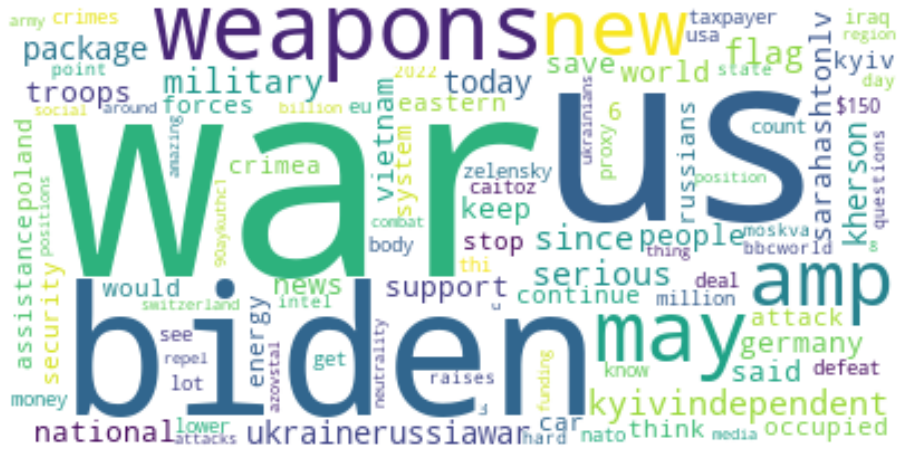

In [36]:
plt.rcParams['figure.figsize'] = (16,9)
wordcloud = WordCloud(background_color='white', collocations=False, max_words=100).fit_words(freq_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()